# Import Statements

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# Read the data

In [3]:
data = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_correctdates.csv")

In [4]:
data["datetime"] = pd.to_datetime(data["datetime"])

In [5]:
data = data.set_index("datetime")
data.head()

,avg cpu,max cpu
datetime,,
2016-11-16 00:00:00,1.229569e+06,2.223302e+06
2016-11-16 00:05:00,1.211322e+06,2.212393e+06
2016-11-16 00:10:00,1.206635e+06,2.213057e+06
2016-11-16 00:15:00,1.190369e+06,2.187572e+06
2016-11-16 00:20:00,1.180992e+06,2.183684e+06


# Detrend the Data

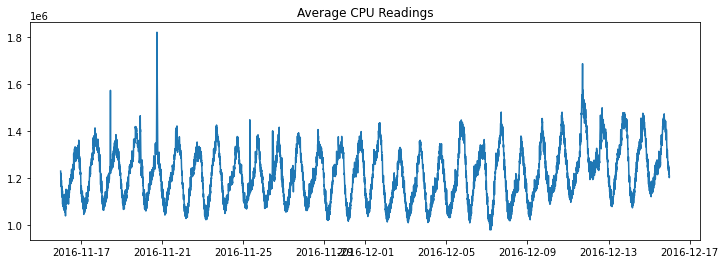

In [6]:
plt.figure(figsize=(12,4))
plt.plot(data["avg cpu"])
plt.title("Average CPU Readings")
plt.show()

In [7]:
data = data.diff()
data = data.drop(data.head(1).index)

<function matplotlib.pyplot.show(close=None, block=None)>

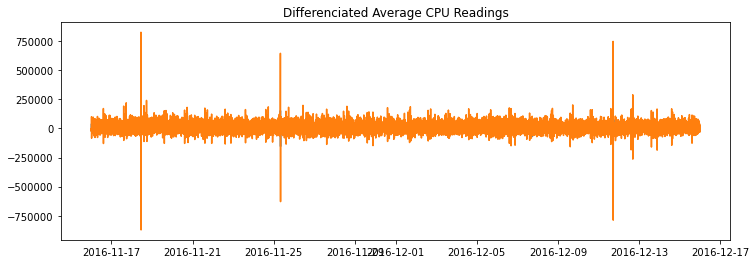

In [8]:
plt.figure(figsize=(12,4))
plt.plot(data)
plt.title("Differenciated Average CPU Readings")
plt.show

# Rolling Window DataFrame
## Window: 48 (4 hour), two step ahead
CPU Readings (Average)

In [55]:
col_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14",
              "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27",
              "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40",
              "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [56]:
windows = 48

rw48_predictions = data.reset_index()

rw48_windows = pd.DataFrame([window.to_list() for window in data["avg cpu"].rolling(window=windows+1)], 
                          columns =  col_names + ["extra"])

rw48_predictions = pd.merge(rw48_predictions, rw48_windows, left_index=True, right_index=True)
           
rw48_predictions.head()

,datetime,avg cpu,max cpu,x1,x2,x3,x4,x5,x6,x7,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,extra
0,2016-11-16 00:05:00,-18247.662562,-10909.187252,-18247.662562,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-16 00:10:00,-4686.794736,663.499454,-18247.662562,-4686.794736,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-16 00:15:00,-16266.407090,-25484.505811,-18247.662562,-4686.794736,-16266.40709,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-16 00:20:00,-9376.819149,-3887.753457,-18247.662562,-4686.794736,-16266.40709,-9376.819149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-11-16 00:25:00,39297.268601,100597.082507,-18247.662562,-4686.794736,-16266.40709,-9376.819149,39297.268601,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
rw48_predictions = rw48_predictions.drop(rw48_predictions.head(windows+1).index) # drop first rows with NAN values

In [58]:
rw48_predictions = rw48_predictions[["datetime", "avg cpu"] + col_names] # drop unnecessary column

In [59]:
train, test = train_test_split(rw48_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6872, 50), (1718, 50))

# Normalise the Data
Scale to -1,1 and only scale the training set. Then apply the training scale to the test set as in real world observations we will not have pre-access to the test data.

In [60]:
scaler = MinMaxScaler()
train[["avg cpu"] + col_names] = scaler.fit_transform(train[["avg cpu"] + col_names])
test[["avg cpu"] + col_names] = scaler.transform(test[["avg cpu"] + col_names])

In [61]:
norm_avg_cpu = pd.concat([train, test])
norm_avg_cpu.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Normalised Data/avg_cpu_reading_norm.csv")

In [62]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['avg cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [63]:
x_train = train[col_names]
y_train = train["avg cpu"]
x_test = test[col_names]
y_test = test["avg cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline
Use the previous observation as a prediction for the next

In [64]:
test["baseline"] = test[["avg cpu"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor
test.head()

,datetime,avg cpu,x1,x2,x3,x4,x5,x6,x7,x8,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6922,2016-12-10 00:55:00,0.567258,0.539511,0.439268,0.424325,0.513734,0.509988,0.454579,0.564466,0.507063,...,0.506410,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.546740
6923,2016-12-10 01:00:00,0.424394,0.439268,0.424325,0.513734,0.509988,0.454579,0.564466,0.507063,0.475198,...,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.567258
6924,2016-12-10 01:05:00,0.435884,0.424325,0.513734,0.509988,0.454579,0.564466,0.507063,0.475198,0.479503,...,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.424394
6925,2016-12-10 01:10:00,0.503821,0.513734,0.509988,0.454579,0.564466,0.507063,0.475198,0.479503,0.476711,...,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.435884,0.435884
6926,2016-12-10 01:15:00,0.493244,0.509988,0.454579,0.564466,0.507063,0.475198,0.479503,0.476711,0.513074,...,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.435884,0.503821,0.503821


### Linear Regression

In [19]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.5057129126309152


In [20]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

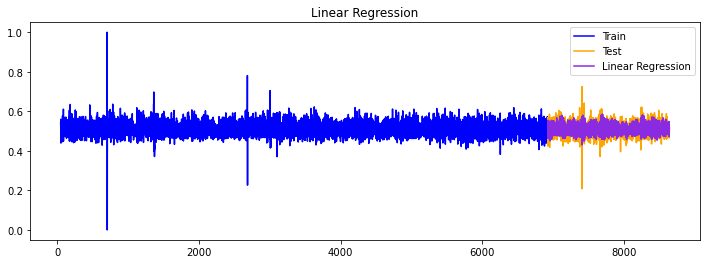

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [22]:
rw48_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["avg cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['avg cpu'], test['baseline']))] })

In [23]:
lr_mape = mean_absolute_error(test["avg cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw48_results = pd.concat([rw48_results, lr_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782


### Decision Tree

In [22]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1252, in fit
    super().fit(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 351, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'squared_error'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan  0.29421732  0.33833504
  0.22056638 -0.08113371         nan         nan         nan         nan
 -0.00059056 -0.00053819  0.01294828 -0.00710312]
  warnings.warn(


The best params are:
{'criterion': 'friedman_mse', 'max_depth': 5}
0.3383350425226138


In [28]:
dt_reg = DecisionTreeRegressor(criterion="friedman_mse", max_depth=5, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

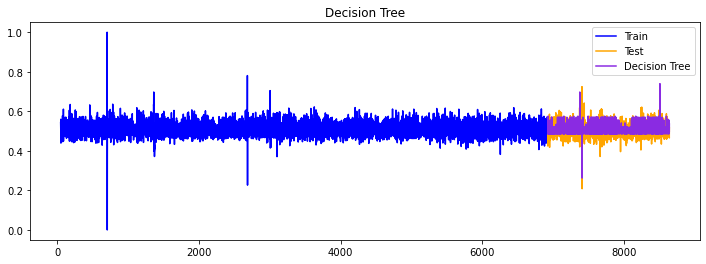

In [29]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [30]:
dt_mape = mean_absolute_error(test["avg cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw48_results = pd.concat([rw48_results, dt_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782
0,Decision Tree,0.018998,0.025828


### Random Forest


In [23]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan  0.33299336  0.39007182  0.43503499
         nan         nan         nan  0.00204143  0.01765305  0.07172642
         nan         nan         nan  0.29421732  0.33838132  0.31566386
         nan         nan         nan -0.00059056 -0.00053819  0.01294828]
  warnings.warn(


The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.43503498621710385


In [31]:
rf = RandomForestRegressor(bootstrap=True, criterion="friedman_mse", max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

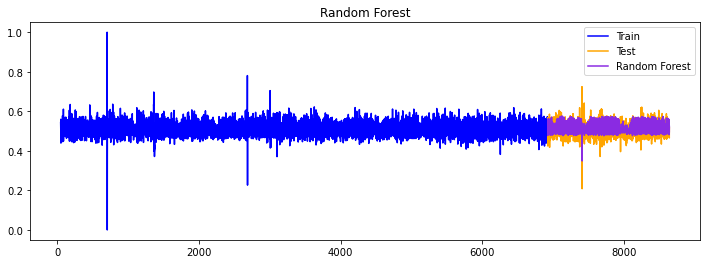

In [32]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [33]:
rf_mape = mean_absolute_error(test["avg cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw48_results = pd.concat([rw48_results, rf_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782
0,Decision Tree,0.018998,0.025828
0,Random Forest,0.017163,0.023021


### Gradient Boosting

In [24]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1252, in fit
    super().fit(
  File "C:\Users\user\anaconda3\lib\site-packag

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 300}
0.512865239139891


In [65]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=300, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

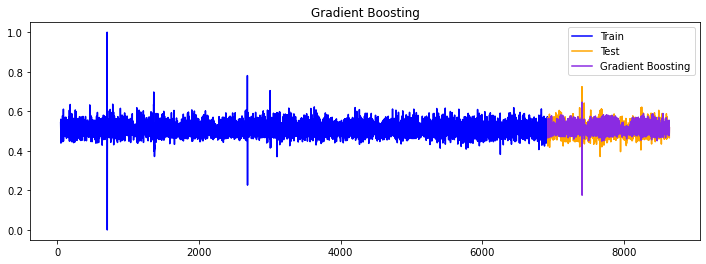

In [66]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

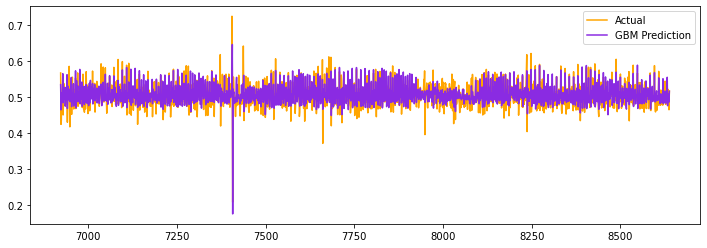

In [71]:
plt.figure(figsize=(12,4))
plt.plot(test['avg cpu'], label='Actual', color="orange")
plt.plot(test['gb_pred'], label='GBM Prediction', color="blueviolet")

plt.legend(loc='best')
# plt.title('Gradient Boosting')
plt.show()

In [36]:
gb_mape = mean_absolute_error(test["avg cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw48_results = pd.concat([rw48_results, gb_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782
0,Decision Tree,0.018998,0.025828
0,Random Forest,0.017163,0.023021
0,Gradient Boosting,0.015935,0.021757


### K Nearest Neighbours

In [25]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
0.47141515484526636


In [37]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

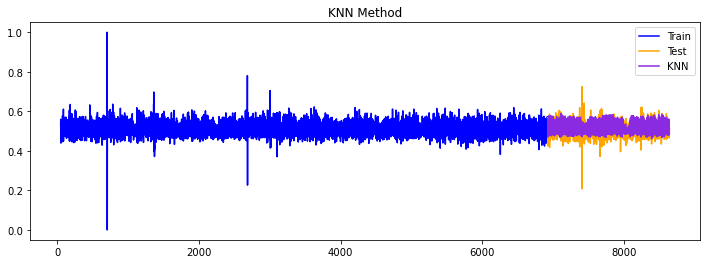

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [39]:
knn_mape = mean_absolute_error(test["avg cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw48_results = pd.concat([rw48_results, knn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782
0,Decision Tree,0.018998,0.025828
0,Random Forest,0.017163,0.023021
0,Gradient Boosting,0.015935,0.021757
0,KNN,0.016943,0.023514


### Neural Network

In [26]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'tanh', 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.5033403175266895


In [40]:
nn_model = MLPRegressor(activation="tanh", hidden_layer_sizes=150, learning_rate="constant", random_state=1, 
                        max_iter=250, solver="lbfgs")
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

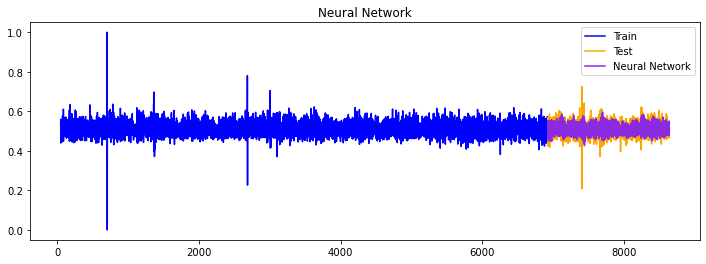

In [41]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [42]:
nn_mape = mean_absolute_error(test["avg cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw48_results = pd.concat([rw48_results, nn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782
0,Decision Tree,0.018998,0.025828
0,Random Forest,0.017163,0.023021
0,Gradient Boosting,0.015935,0.021757
0,KNN,0.016943,0.023514
0,Neural Network,0.017146,0.023694


### Simple Moving Average

In [27]:
test["sma_pred"] = list(test[col_names].mean(axis=1))[1:] + [0]

In [43]:
test = test.drop(test.tail(1).index) # Drop last row

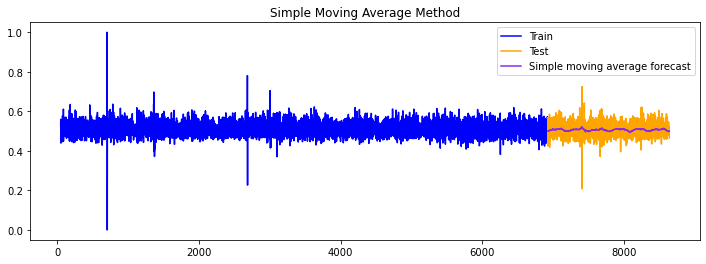

In [44]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [45]:
sma_mape = mean_absolute_error(test["avg cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw48_results = pd.concat([rw48_results, sma_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.016394,0.022782
0,Decision Tree,0.018998,0.025828
0,Random Forest,0.017163,0.023021
0,Gradient Boosting,0.015935,0.021757
0,KNN,0.016943,0.023514
0,Neural Network,0.017146,0.023694
0,Simple Moving Avg.,0.023718,0.031948


## Window: 24 (2 hours)

In [33]:
window = 24

rw24_predictions = rw48_predictions[["datetime", "avg cpu", "x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32",
                                    "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw24_predictions.head()

,datetime,avg cpu,x25,x26,x27,x28,x29,x30,x31,x32,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,20549.207316,-4191.971910,-32927.273259,-21013.934392,37093.152799,-216.129139,-8003.638560,-1463.313816,-26923.496591,...,-9646.696670,12309.014756,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926
50,2016-11-16 04:15:00,8241.225887,-32927.273259,-21013.934392,37093.152799,-216.129139,-8003.638560,-1463.313816,-26923.496591,-9541.197816,...,12309.014756,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316
51,2016-11-16 04:20:00,-1755.280138,-21013.934392,37093.152799,-216.129139,-8003.638560,-1463.313816,-26923.496591,-9541.197816,20149.136017,...,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316,8241.225887
52,2016-11-16 04:25:00,29923.176622,37093.152799,-216.129139,-8003.638560,-1463.313816,-26923.496591,-9541.197816,20149.136017,-2504.580398,...,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316,8241.225887,-1755.280138
53,2016-11-16 04:30:00,-37012.793506,-216.129139,-8003.638560,-1463.313816,-26923.496591,-9541.197816,20149.136017,-2504.580398,7907.039205,...,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316,8241.225887,-1755.280138,29923.176622


In [34]:
train, test = train_test_split(rw24_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6872, 26), (1718, 26))

# Normalise the Data
Scale to -1,1 and only scale the training set. Then apply the training scale to the test set as in real world observations we will not have pre-access to the test data.

In [35]:
col_names = ["x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [36]:
scaler = MinMaxScaler()
train[["avg cpu"] + col_names] = scaler.fit_transform(train[["avg cpu"] + col_names])
test[["avg cpu"] + col_names] = scaler.transform(test[["avg cpu"] + col_names])

In [37]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['avg cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [38]:
x_train = train[col_names]
y_train = train["avg cpu"]
x_test = test[col_names]
y_test = test["avg cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [39]:
test["baseline"] = test[["avg cpu"]].shift(1)
test = test.drop(test.head(1).index)
test.head()

,datetime,avg cpu,x25,x26,x27,x28,x29,x30,x31,x32,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6922,2016-12-10 00:55:00,0.567258,0.513389,0.439036,0.484232,0.511114,0.524581,0.504864,0.526445,0.472157,...,0.506410,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.546740
6923,2016-12-10 01:00:00,0.424394,0.439036,0.484232,0.511114,0.524581,0.504864,0.526445,0.472157,0.515455,...,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.567258
6924,2016-12-10 01:05:00,0.435884,0.484232,0.511114,0.524581,0.504864,0.526445,0.472157,0.515455,0.511189,...,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.424394
6925,2016-12-10 01:10:00,0.503821,0.511114,0.524581,0.504864,0.526445,0.472157,0.515455,0.511189,0.494607,...,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.435884,0.435884
6926,2016-12-10 01:15:00,0.493244,0.524581,0.504864,0.526445,0.472157,0.515455,0.511189,0.494607,0.500405,...,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.435884,0.503821,0.503821


### Linear Regression

In [54]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.4717557571312313


In [55]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

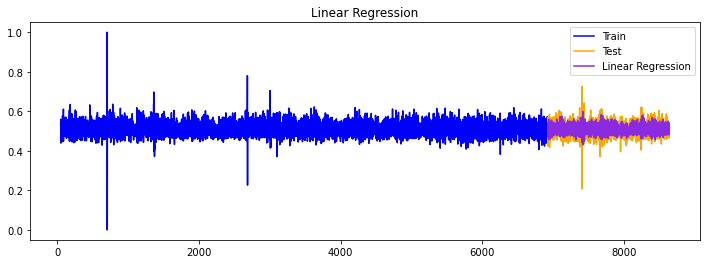

In [56]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [76]:
rw24_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["avg cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['avg cpu'], test['baseline']))] })

In [77]:
lr_mape = mean_absolute_error(test["avg cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw24_results = pd.concat([rw24_results, lr_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627


### Decision Tree

In [59]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 5}
0.3323668239898421


In [65]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

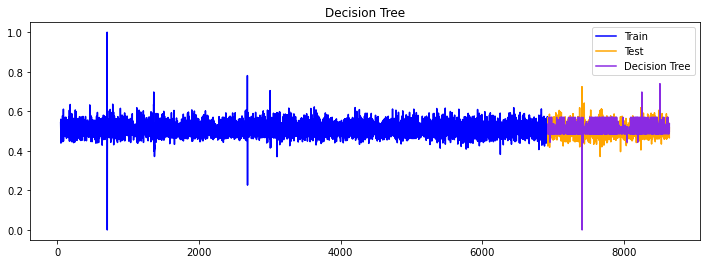

In [66]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [78]:
dt_mape = mean_absolute_error(test["avg cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw24_results = pd.concat([rw24_results, dt_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627
0,Decision Tree,0.019404,0.026998


### Random Forest

In [60]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.4188121302406325


In [68]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

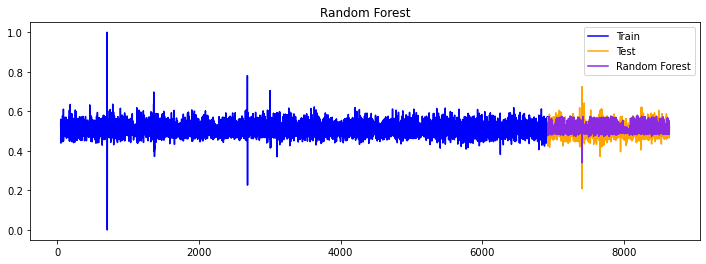

In [69]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [79]:
rf_mape = mean_absolute_error(test["avg cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw24_results = pd.concat([rw24_results, rf_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627
0,Decision Tree,0.019404,0.026998
0,Random Forest,0.017267,0.023326


### Gradient Boosting

In [61]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 300}
0.47970457998078364


In [40]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=300, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

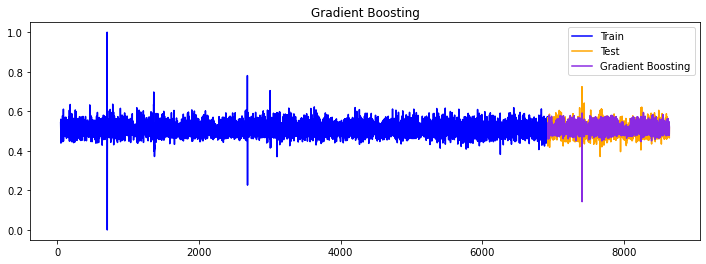

In [41]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

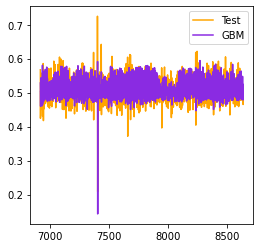

In [42]:
plt.figure(figsize=(4,4))
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='GBM', color="blueviolet")
plt.legend(loc='best')
# plt.title('Gradient Boosting')
plt.show()

In [81]:
gb_mape = mean_absolute_error(test["avg cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw24_results = pd.concat([rw24_results, gb_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627
0,Decision Tree,0.019404,0.026998
0,Random Forest,0.017267,0.023326
0,Gradient Boosting,0.016528,0.022321


### K Nearest Neighbours

In [62]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.43360154634373715


In [82]:
knn_model = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

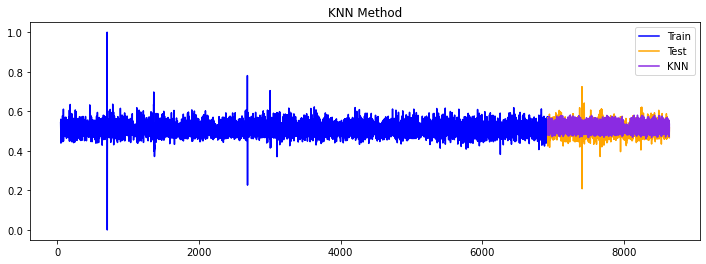

In [83]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [84]:
knn_mape = mean_absolute_error(test["avg cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw24_results = pd.concat([rw24_results, knn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627
0,Decision Tree,0.019404,0.026998
0,Random Forest,0.017267,0.023326
0,Gradient Boosting,0.016528,0.022321
0,KNN,0.017137,0.024042


### Neural Network

In [63]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.45306699163423403


In [72]:
nn_model = MLPRegressor(activation="relu", hidden_layer_sizes=200, learning_rate="constant", random_state=1, 
                        max_iter=200, solver="lbfgs")
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

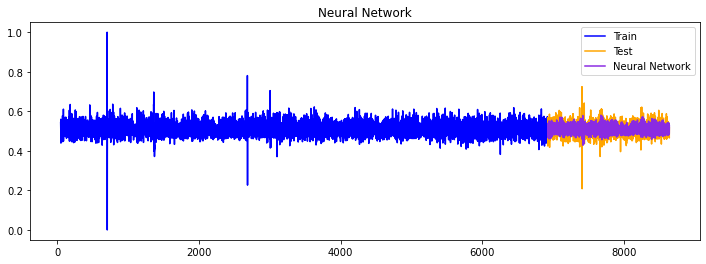

In [73]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [85]:
nn_mape = mean_absolute_error(test["avg cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw24_results = pd.concat([rw24_results, nn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627
0,Decision Tree,0.019404,0.026998
0,Random Forest,0.017267,0.023326
0,Gradient Boosting,0.016528,0.022321
0,KNN,0.017137,0.024042
0,Neural Network,0.017131,0.023818


### Simple Moving Average

In [64]:
test["sma_pred"] = list(test[col_names].mean(axis=1))[1:] + [0]

In [86]:
test = test.drop(test.tail(1).index) # Drop last row

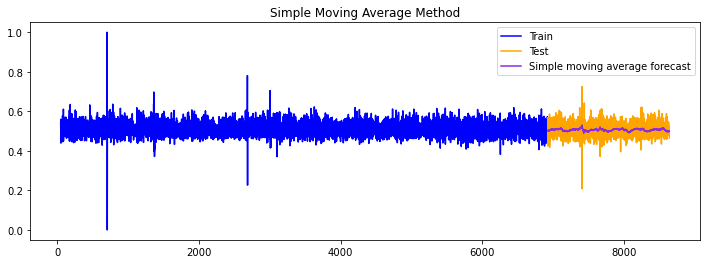

In [87]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [88]:
sma_mape = mean_absolute_error(test["avg cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw24_results = pd.concat([rw24_results, sma_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.017037,0.023627
0,Decision Tree,0.019404,0.026998
0,Random Forest,0.017267,0.023326
0,Gradient Boosting,0.016528,0.022321
0,KNN,0.017137,0.024042
0,Neural Network,0.017131,0.023818
0,Simple Moving Avg.,0.023588,0.031809


## Window: 12 (60 minutes)

In [43]:
col_names = ["x37", "x38", "x39", "x40", "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [44]:
window = 12

rw12_predictions = rw48_predictions[["datetime", "avg cpu", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw12_predictions.head()

,datetime,avg cpu,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,20549.207316,1587.114619,-12352.566041,-9646.696670,12309.014756,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926
50,2016-11-16 04:15:00,8241.225887,-12352.566041,-9646.696670,12309.014756,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316
51,2016-11-16 04:20:00,-1755.280138,-9646.696670,12309.014756,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316,8241.225887
52,2016-11-16 04:25:00,29923.176622,12309.014756,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316,8241.225887,-1755.280138
53,2016-11-16 04:30:00,-37012.793506,-23027.933488,-4773.487265,6630.081802,-9506.461866,-2531.435526,25057.838587,-16218.371312,1322.413926,20549.207316,8241.225887,-1755.280138,29923.176622


In [45]:
train, test = train_test_split(rw12_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6872, 14), (1718, 14))

# Normalise the Data
Scale to -1,1 and only scale the training set. Then apply the training scale to the test set as in real world observations we will not have pre-access to the test data.

In [46]:
scaler = MinMaxScaler()
train[["avg cpu"] + col_names] = scaler.fit_transform(train[["avg cpu"] + col_names])
test[["avg cpu"] + col_names] = scaler.transform(test[["avg cpu"] + col_names])

In [47]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['avg cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [48]:
x_train = train[col_names]
y_train = train["avg cpu"]
x_test = test[col_names]
y_test = test["avg cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### baseline

In [50]:
test["baseline"] = test[["avg cpu"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor
test.head()

,datetime,avg cpu,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6922,2016-12-10 00:55:00,0.567258,0.497149,0.474742,0.507732,0.506410,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.546740
6923,2016-12-10 01:00:00,0.424394,0.474742,0.507732,0.506410,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.567258
6924,2016-12-10 01:05:00,0.435884,0.507732,0.506410,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.424394
6925,2016-12-10 01:10:00,0.503821,0.506410,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.435884,0.435884
6926,2016-12-10 01:15:00,0.493244,0.471999,0.509106,0.572413,0.443406,0.517829,0.526405,0.490813,0.546740,0.567258,0.424394,0.435884,0.503821,0.503821


### Linear Regression

In [96]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.39482850083042476


In [97]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

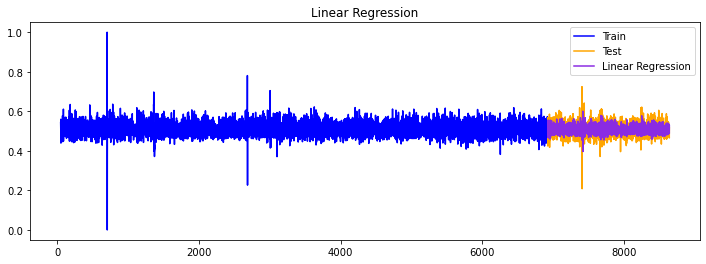

In [98]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [99]:
rw12_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["avg cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['avg cpu'], test['baseline']))] })

In [100]:
lr_mape = mean_absolute_error(test["avg cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw12_results = pd.concat([rw12_results, lr_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346


### Decision Tree

In [101]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 5}
0.29828083213055656


In [107]:
dt_reg = DecisionTreeRegressor(criterion="friedman_mse", max_depth=5, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

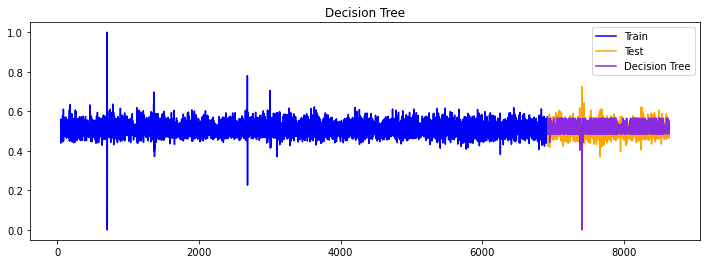

In [108]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [109]:
dt_mape = mean_absolute_error(test["avg cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw12_results = pd.concat([rw12_results, dt_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346
0,Decision Tree,0.019045,0.025644


### Random Forest

In [102]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.3747575944191301


In [110]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

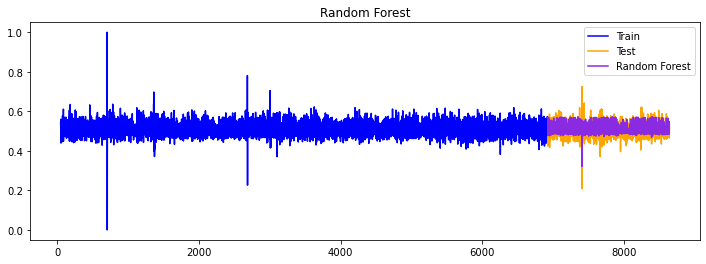

In [111]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [112]:
rf_mape = mean_absolute_error(test["avg cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw12_results = pd.concat([rw12_results, rf_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346
0,Decision Tree,0.019045,0.025644
0,Random Forest,0.017712,0.023754


### Gradient Boosting

In [103]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 300}
0.4319212634451941


In [51]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=300, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

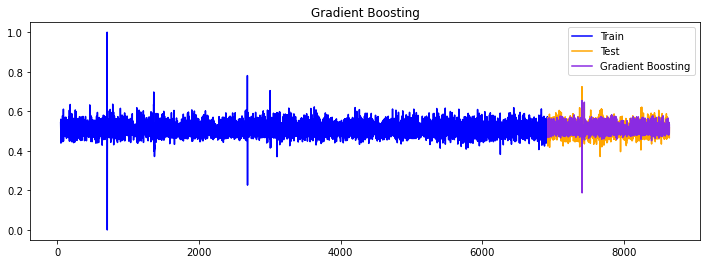

In [52]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

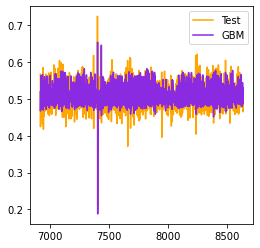

In [54]:
plt.figure(figsize=(4,4))
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='GBM', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [115]:
gb_mape = mean_absolute_error(test["avg cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw12_results = pd.concat([rw12_results, gb_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346
0,Decision Tree,0.019045,0.025644
0,Random Forest,0.017712,0.023754
0,Gradient Boosting,0.017472,0.023735


### K Nearest Neighbours

In [104]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'distance'}
0.3978888732128787


In [116]:
knn_model = KNeighborsRegressor(algorithm='brute', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

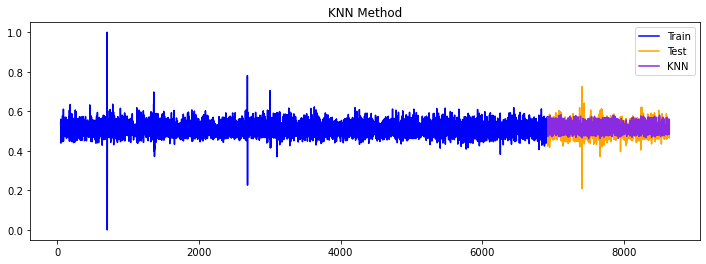

In [117]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [118]:
knn_mape = mean_absolute_error(test["avg cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw12_results = pd.concat([rw12_results, knn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346
0,Decision Tree,0.019045,0.025644
0,Random Forest,0.017712,0.023754
0,Gradient Boosting,0.017472,0.023735
0,KNN,0.017542,0.024297


### Neural Network

In [105]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.3926609249540961


In [119]:
nn_model = MLPRegressor(activation='identity', hidden_layer_sizes=100, learning_rate='constant', max_iter=200, solver='lbfgs',
                        random_state=1)
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

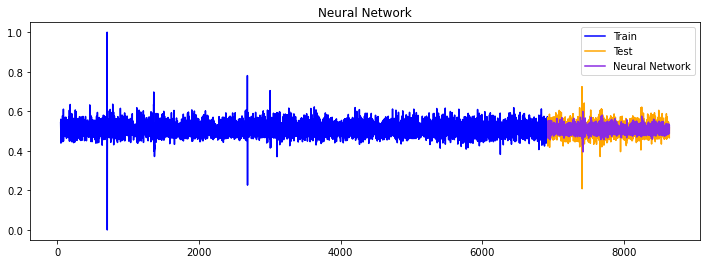

In [120]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [121]:
nn_mape = mean_absolute_error(test["avg cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw12_results = pd.concat([rw12_results, nn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346
0,Decision Tree,0.019045,0.025644
0,Random Forest,0.017712,0.023754
0,Gradient Boosting,0.017472,0.023735
0,KNN,0.017542,0.024297
0,Neural Network,0.018483,0.025479


### Simple Moving Average

In [106]:
test["sma_pred"] = list(test[col_names].mean(axis=1))[1:] + [0]

In [122]:
test = test.drop(test.tail(1).index) # Drop last row

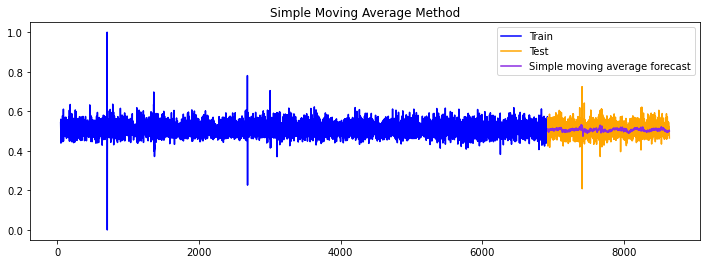

In [123]:
plt.figure(figsize=(12,4))
plt.plot(train['avg cpu'], label='Train', color="b")
plt.plot(test['avg cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [124]:
sma_mape = mean_absolute_error(test["avg cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['avg cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw12_results = pd.concat([rw12_results, sma_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.035697,0.047993
0,Linear Regression,0.018445,0.025346
0,Decision Tree,0.019045,0.025644
0,Random Forest,0.017712,0.023754
0,Gradient Boosting,0.017472,0.023735
0,KNN,0.017542,0.024297
0,Neural Network,0.018483,0.025479
0,Simple Moving Avg.,0.023439,0.031588


# Result Comparision

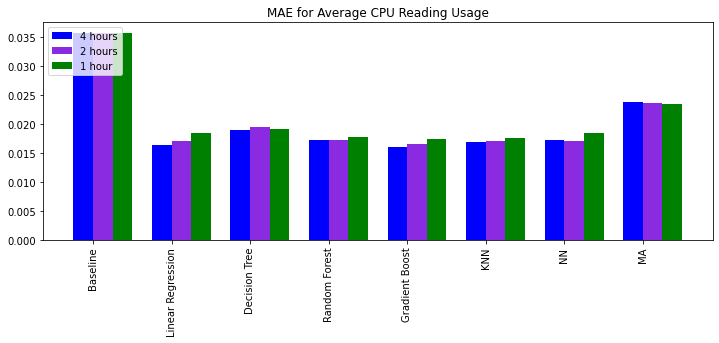

In [125]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["MAE"], width=width, label="4 hours", color="b")
plt.bar(r+width, rw24_results["MAE"], width=width, label="2 hours", color="blueviolet")
plt.bar(r+width+width, rw12_results["MAE"], width=width, label="1 hour", color="g")
plt.legend(loc='upper left')
plt.title("MAE for Average CPU Reading Usage")
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN', 'NN', 'MA'], rotation=90)
plt.show()

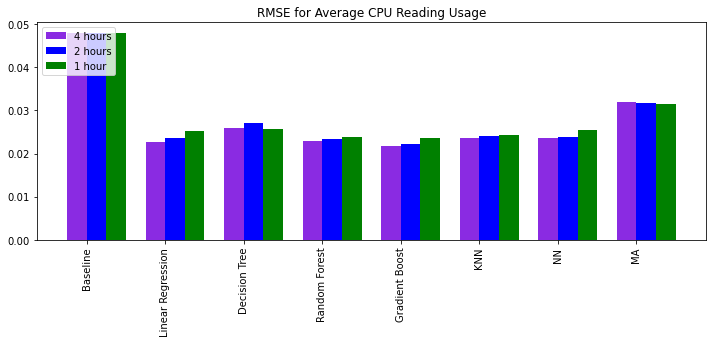

In [126]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["RMSE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["RMSE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["RMSE"], width=width, label="1 hour", color="g")
plt.legend(loc='upper left')
plt.title("RMSE for Average CPU Reading Usage")
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN','NN', 'MA'], rotation=90)
plt.show()

In [127]:
rw48_results = rw48_results.reset_index()
rw24_results = rw24_results.reset_index()
rw12_results = rw12_results.reset_index()

In [128]:
total_results = pd.merge(rw48_results, rw24_results, on='Method', how='outer')
total_results = pd.merge(total_results, rw12_results, on='Method', how='outer')
total_results

,index_x,Method,MAE_x,RMSE_x,index_y,MAE_y,RMSE_y,index,MAE,RMSE
0,0,Baseline,0.035697,0.047993,0,0.035697,0.047993,0,0.035697,0.047993
1,0,Linear Regression,0.016394,0.022782,0,0.017037,0.023627,0,0.018445,0.025346
2,0,Decision Tree,0.018998,0.025828,0,0.019404,0.026998,0,0.019045,0.025644
3,0,Random Forest,0.017163,0.023021,0,0.017267,0.023326,0,0.017712,0.023754
4,0,Gradient Boosting,0.015935,0.021757,0,0.016528,0.022321,0,0.017472,0.023735
5,0,KNN,0.016943,0.023514,0,0.017137,0.024042,0,0.017542,0.024297
6,0,Neural Network,0.017146,0.023694,0,0.017131,0.023818,0,0.018483,0.025479
7,0,Simple Moving Avg.,0.023718,0.031948,0,0.023588,0.031809,0,0.023439,0.031588


In [129]:
total_results = total_results[["Method","MAE_x", "RMSE_x", "MAE_y", "RMSE_y", "MAE", "RMSE"]]

In [130]:
total_results = total_results.rename(columns={total_results.columns[0]: "Methods", 
                                              total_results.columns[1]: "MAE (w=48)", total_results.columns[2]: "RMSE (w=48)", 
                                              total_results.columns[3]: "MAE (w=24)", total_results.columns[4]: "RMSE (w=24)", 
                                              total_results.columns[5]: "MAE (w=12)", total_results.columns[6]: "RMSE (w=12)", 
                                            })

In [131]:
total_results.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Results/avg_cpu_readings_results.csv")